# 載入函式庫 & 掛載雲端硬碟

In [ ]:
import os
from google.colab import drive

import copy
import numpy
import numpy as np
import pandas as pd
import librosa

import tensorflow as tf
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, LayerNormalization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import datasets, layers, models

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier

drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/Colab Notebooks/Voice-Diease/')

Mounted at /content/drive


## 載入訓練資料

In [ ]:
# 讀取訓練資料集表單
source_df = pd.read_csv('./data/training_datalist.csv')

print("source_df.shape :", source_df.shape)
# print("source_df.columns :", source_df.columns)

source_df.shape : (1000, 28)


## 切分訓練與驗證資料

In [ ]:
training_df, validate_df = train_test_split(source_df, test_size=0.15, random_state=333)

print("training_df shape :", training_df.shape, ", validate_df shape :", validate_df.shape)

training_df shape : (850, 28) , validate_df shape : (150, 28)


## 文字資料前處理

In [ ]:
def medical_data_proccessing(input_df):
    df = copy.deepcopy(input_df)
    # 將性別編碼0,1
    df['Sex'] = df['Sex'] - 1

    # 將空值填0
    df['PPD'] = df['PPD'].fillna(0)
    df['Voice handicap index - 10'] = df['Voice handicap index - 10'].fillna(0)

    # 正規化過大的數值
    #problem : use training data to normalize 
    df['Age'] = df['Age'] / 100
    df['Voice handicap index - 10'] = df['Voice handicap index - 10'] / 40
    df['Occupational vocal demand'] /= 4
    df['Diurnal pattern'] /= 4
    df['Noise at work'] /= 3
    df['Onset of dysphonia '] /= 5
    df['frequency'] /= 3
    df['Drinking'] /= 2
    df['Smoking'] /= 3
    ## PPD just temp divided by 3
    df['PPD'] /= 3

    return df

In [ ]:
y_train = pd.get_dummies(training_df, columns=['Disease category']).to_numpy()[:,-5:].astype('float32')
x_train = medical_data_proccessing(training_df).drop(['Disease category','ID'], axis=1).to_numpy()
print(x_train.shape, y_train.shape)


y_val = pd.get_dummies(validate_df, columns=['Disease category']).to_numpy()[:,-5:].astype('float32')
x_val = medical_data_proccessing(validate_df).drop(['Disease category','ID'], axis=1).to_numpy()
print(x_val.shape, y_val.shape)

(850, 26) (850, 5)
(150, 26) (150, 5)


## 模型

In [ ]:
# default hyperparameters
NEURONS = 200
HIDDEN_LAYERS = 5

def create_text_DNN(input_shape, neurons = NEURONS, hidden_layers = HIDDEN_LAYERS, learning_rate = 0.0001, verbose=0):
    model = Sequential()

    model.add(Dense(neurons, input_dim=input_shape))
    model.add(Activation('relu'))
    model.add(layers.Dropout(0.5))
    #model.add(BatchNormalization())
    model.add(LayerNormalization())

    for i in range(hidden_layers-1):
        model.add(Dense(neurons))
        model.add(Activation('relu'))
        model.add(layers.Dropout(0.5))
        #model.add(BatchNormalization())
        model.add(LayerNormalization())

    model.add(Dense(5))
    model.add(Activation('softmax'))

    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) # categorical_crossentropy

    if verbose:
        model.summary()
    
    return model

## Tradition Model

In [ ]:
mnb = GaussianNB()
clf = mnb.fit(x_train, np.argmax(y_train, axis=1))
y_pred = clf.predict(x_val)

print(((clf.predict(x_train)) == np.argmax(y_train, axis=1)).sum() / len(y_train))
print((clf.predict(x_val) == np.argmax(y_val, axis=1)).sum() / len(y_val))

results_recall = recall_score(y_true, y_pred, average=None)
print("Test UAR(Unweighted Average Recall) :", results_recall.mean())

0.08235294117647059
0.06666666666666667
Test UAR(Unweighted Average Recall) : 0.28547008547008546


In [ ]:
clf = LogisticRegression(class_weight=class_weight, max_iter=1000)
clf = clf.fit(x_train, np.argmax(y_train, axis=1))
y_pred = clf.predict(x_val)

print(( clf.predict(x_train) == np.argmax(y_train, axis=1)).sum() / len(y_train))
print((clf.predict(x_val) == np.argmax(y_val, axis=1)).sum() / len(y_val))

results_recall = recall_score(y_true, y_pred, average=None)
print("Test UAR(Unweighted Average Recall) :", results_recall.mean())

0.54
0.6
Test UAR(Unweighted Average Recall) : 0.6260054329821771


In [ ]:
clf = SGDClassifier(loss='hinge')
clf = clf.fit(x_train, np.argmax(y_train, axis=1))
y_pred = clf.predict(x_val)

print(( clf.predict(x_train) == np.argmax(y_train, axis=1)).sum() / len(y_train))
print((clf.predict(x_val) == np.argmax(y_val, axis=1)).sum() / len(y_val))

results_recall = recall_score(y_true, y_pred, average=None)
print("Test UAR(Unweighted Average Recall) :", results_recall.mean())

0.5447058823529412
0.6266666666666667
Test UAR(Unweighted Average Recall) : 0.3991718014973829


In [ ]:
np.random.seed(42)
X = medical_data_proccessing(source_df).drop(['Disease category','ID'], axis=1).to_numpy()
y = np.array(source_df['Disease category']) - 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_classifier = SVC(kernel="sigmoid", C=1, gamma="auto", random_state=42, probability=True, decision_function_shape='ovr', class_weight=class_weight)
svm_classifier.fit(X_train_scaled, y_train)
y_pred = svm_classifier.predict(X_test_scaled)

results_recall = recall_score(y_test, y_pred, average=None)
print("Test UAR(Unweighted Average Recall) :", results_recall.mean())

Test UAR(Unweighted Average Recall) : 0.47361437184692995


## 訓練

In [ ]:
text_model = create_text_DNN(input_shape = x_train.shape[1], verbose=0)

In [ ]:
class_weight = {0: 1.,
                1: 2.436,
                2: 3.19,
                3: 12.182,
                4: 16.75,}

train_results = text_model.fit(x_train, y_train, batch_size=256, epochs=10000, class_weight=class_weight,

                              callbacks=[EarlyStopping(monitor='val_loss', patience=3000, mode='auto'),
                                         ModelCheckpoint("text_model.h6", save_best_only=True, monitor='val_accuracy')
                                         ], 
                              validation_data=(x_val, y_val))

串流輸出內容已截斷至最後 5000 行。
4/4 [==============================] - 0s 29ms/step - loss: 1.1747 - accuracy: 0.7376 - val_loss: 2.2475 - val_accuracy: 0.5933
Epoch 959/10000
4/4 [==============================] - 0s 23ms/step - loss: 1.3694 - accuracy: 0.7318 - val_loss: 2.2528 - val_accuracy: 0.5933
Epoch 960/10000
4/4 [==============================] - 0s 31ms/step - loss: 1.2887 - accuracy: 0.7588 - val_loss: 2.2630 - val_accuracy: 0.5933
Epoch 961/10000
4/4 [==============================] - 0s 27ms/step - loss: 1.1960 - accuracy: 0.7518 - val_loss: 2.2772 - val_accuracy: 0.5933
Epoch 962/10000
4/4 [==============================] - 0s 21ms/step - loss: 1.2026 - accuracy: 0.7353 - val_loss: 2.2879 - val_accuracy: 0.5867
Epoch 963/10000
4/4 [==============================] - 0s 25ms/step - loss: 1.2055 - accuracy: 0.7459 - val_loss: 2.2921 - val_accuracy: 0.5867
Epoch 964/10000
4/4 [==============================] - 0s 28ms/step - loss: 1.2623 - accuracy: 0.7494 - val_loss: 2.2981 - val_accu

## 結果

27/27 [==============================] - 0s 2ms/step
Training UAR(Unweighted Average Recall) : 0.9530523891767416


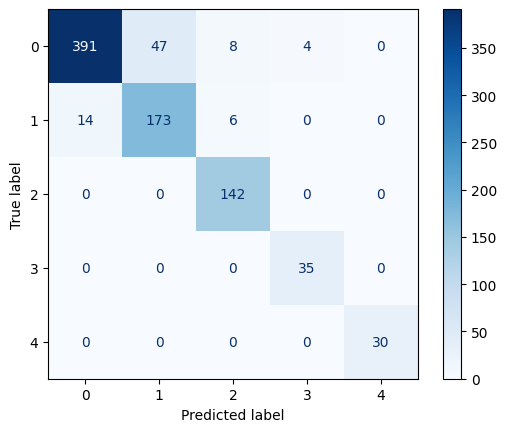

In [ ]:
y_pred = text_model.predict(x_train).argmax(axis=1)
y_true = training_df['Disease category'] - 1

results_recall = recall_score(y_true, y_pred, average=None)
print("Training UAR(Unweighted Average Recall) :", results_recall.mean())
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot(cmap='Blues')

5/5 [==============================] - 0s 4ms/step
Test UAR(Unweighted Average Recall) : 0.375763599019413


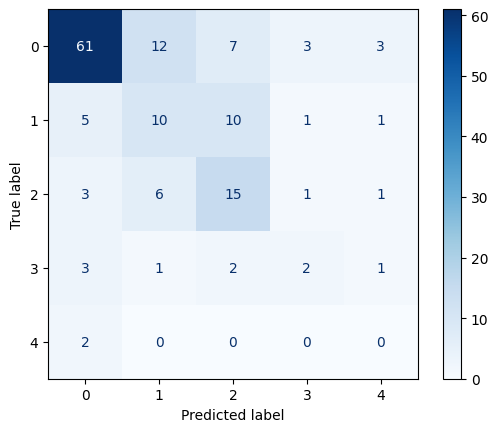

In [ ]:
text_model = load_model("text_model.h5")
y_pred = text_model.predict(x_val).argmax(axis=1)
y_true = validate_df['Disease category'] - 1

results_recall = recall_score(y_true, y_pred, average=None)
print("Test UAR(Unweighted Average Recall) :", results_recall.mean())
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot(cmap='Blues')